In [1]:
import time
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from datasets import Dataset
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from torch import nn
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")
with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 50
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
bert:
  params:
    model_path: microsoft/deberta-v3-large
    metric: auc
    target_col_class_num: 2
    max_length: 192
    fp16: true
    learning_rate: 2.0e-05
    epochs: 2
    per_device_train_batch_size: 8
    per_device_eval_batch_size: 32
    steps: 50
    lr_scheduler_type: cosine
    weight_decay: 0.01
exp_number: '009'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  clothing_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/009/base
se

### 前処理

In [2]:
debug = False

train_df = pd.read_csv(cfg.data.train_path)
clothing_df = pd.read_csv(cfg.data.clothing_path)
test_df = pd.read_csv(cfg.data.test_path)

if debug:
    train_df = train_df.sample(1000, random_state=cfg.seed).reset_index(drop=True)

train_df = pd.merge(train_df, clothing_df, on="Clothing ID", how="left")
test_df = pd.merge(test_df, clothing_df, on="Clothing ID", how="left")
all_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# 特徴量作成
grp_col = "Clothing ID"
num_features = ["Age", "Positive Feedback Count"]
grp_df = all_df.groupby(grp_col)[num_features].mean().map(int).reset_index()
grp_df.columns = [grp_col] + [f"{col}_grp_mean" for col in num_features]
train_df = pd.merge(train_df, grp_df, on=grp_col, how="left")
test_df = pd.merge(test_df, grp_df, on=grp_col, how="left")

# prompt作成
def preprocess(df):
    df["prompt"] = "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none") + " [SEP] " + "Clothing: ID is " + df["Clothing ID"].map(str) + ", Category is " + df["Class Name"] + ", Purchaser age mean is " + df["Age_grp_mean"].map(str) + ", Positive Feedback Count mean is " + df["Positive Feedback Count_grp_mean"].map(str) + ". [SEP] " + "Review: Reviewer's age is " + df["Age"].map(str) + ", Positive Feedback Count is " + df["Positive Feedback Count"].map(str)
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)
train_df["labels"] = train_df[cfg.target].astype(np.int8)

display(train_df["prompt"][0])

tokenizer = AutoTokenizer.from_pretrained(cfg.bert.params.model_path)
train_max_length = train_df["prompt"].map(lambda x: len(tokenizer(x)["input_ids"])).max()
test_max_length = test_df["prompt"].map(lambda x: len(tokenizer(x)["input_ids"])).max()

print(train_max_length, test_max_length)


"TITLE: 3-season skirt! [SEP] REVIEW: Adorable, well-made skirt! lined and very slimming. i had to size up b/c it runs a bit snug around the waist. however, it's worth it b/c this will match many long and short sleeve tops! [SEP] Clothing: ID is 0, Category is Skirts, Purchaser age mean is 45, Positive Feedback Count mean is 2. [SEP] Review: Reviewer's age is 25, Positive Feedback Count is 4"

206 205


In [3]:
kf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

# Clothing IDをtargetにstratified kfoldするための準備
train_df['fold'] = 99
train_df['index'] = train_df.index
train_df_0 = train_df[train_df[cfg.target] == 0].reset_index(drop=True)
train_df_1 = train_df[train_df[cfg.target] == 1].reset_index(drop=True)

# それぞれのデータフレームで、Clothing IDをtargetにstratified kfoldし、それぞれのfoldを結合
for fold, (_, val_id) in enumerate(kf.split(train_df_0, train_df_0['Clothing ID'])):
    train_df_0.loc[val_id, 'fold'] = fold
for fold, (_, val_id) in enumerate(kf.split(train_df_1, train_df_1['Clothing ID'])):
    train_df_1.loc[val_id, 'fold'] = fold

train_df = pd.concat([train_df_0, train_df_1]).set_index('index').sort_index()
display(train_df.head(2))

assert train_df['fold'].nunique() == cfg.n_splits
assert train_df['fold'].max() == cfg.n_splits - 1


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Age_grp_mean,Positive Feedback Count_grp_mean,prompt,labels,fold
index,,,,,,,,,,,,,,,
0,0,25,3-season skirt!,"Adorable, well-made skirt! lined and very slim...",5,1,4,General,Bottoms,Skirts,45,2,"TITLE: 3-season skirt! [SEP] REVIEW: Adorable,...",1,0
1,0,39,Very cute,Love the asymmetrical hem. waist fit snugly as...,5,1,0,General,Bottoms,Skirts,45,2,TITLE: Very cute [SEP] REVIEW: Love the asymme...,1,0


### Smoth Focal Loss

In [4]:
class FocalLoss(nn.Module):
    def __init__(self, reduction="none", alpha=1, gamma=2):
        super().__init__()
        self.reduction = reduction
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1.0 - pt) ** self.gamma * bce_loss
        if self.reduction == "none":
            loss = loss
        elif self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()
        return loss


class SmoothFocalLoss(nn.Module):
    def __init__(self, reduction="mean", alpha=1, gamma=2, smoothing=0.0):
        super().__init__()
        self.reduction = reduction
        self.focal_loss = FocalLoss(reduction="none", alpha=alpha, gamma=gamma)
        self.smoothing = smoothing

    @staticmethod
    def _smooth(targets: torch.Tensor, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothFocalLoss._smooth(targets, self.smoothing)
        loss = self.focal_loss(inputs, targets)
        if self.reduction == "none":
            loss = loss
        elif self.reduction == "sum":
            loss = loss.sum()
        elif self.reduction == "mean":
            loss = loss.mean()
        return loss


class CustomTrainer(Trainer):
    def __init__(self, loss_fn=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.loss_fn is None:
            loss = F.cross_entropy(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            # ロジットとラベルの形状を調整
            logits = logits[:, 1]  # ポジティブクラスのロジットのみを使用
            labels = labels.float()
            loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Smooth Focal Lossのインスタンスを作成
loss_fn = SmoothFocalLoss(alpha=1, gamma=2, smoothing=0)  # 結局gammaしか効かしてない


### 計算が途中でとまっていたため、以下のログにはfold=4の分のみとなっています

In [5]:
def compute_metrics(p):
    preds, labels = p
    preds = torch.softmax(torch.tensor(preds), dim = 1).numpy()
    score = roc_auc_score(labels, preds[:, 1])
    return {'auc': score}

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

y_train = train_df[cfg.target]
oof = np.zeros(len(train_df))

for fold in range(5):

    ds_train = Dataset.from_pandas(train_df[train_df['fold'] != fold][['prompt', 'labels']].copy())
    ds_eval = Dataset.from_pandas(train_df[train_df['fold'] == fold][['prompt', 'labels']].copy())

    tokenizer = AutoTokenizer.from_pretrained(cfg.bert.params.model_path)
    config = AutoConfig.from_pretrained(cfg.bert.params.model_path)
    model = AutoModelForSequenceClassification.from_pretrained(cfg.bert.params.model_path, config=config)

    def tokenize(sample):
        return tokenizer(sample['prompt'], max_length=cfg.bert.params.max_length, truncation=True)

    ds_train = ds_train.map(tokenize).remove_columns(['prompt', 'index'])
    ds_eval = ds_eval.map(tokenize).remove_columns(['prompt', 'index'])

    output_dir = f"{cfg.data.results_dir}/fold{fold}"

    train_args = TrainingArguments(
        output_dir=output_dir,
        fp16=cfg.bert.params.fp16,
        learning_rate=cfg.bert.params.learning_rate,
        num_train_epochs=cfg.bert.params.epochs,
        per_device_train_batch_size=cfg.bert.params.per_device_train_batch_size,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        gradient_accumulation_steps=4,
        report_to="none",
        evaluation_strategy="steps",
        do_eval=True,
        eval_steps=cfg.bert.params.steps,
        save_total_limit=1,
        save_strategy="steps",
        save_steps=cfg.bert.params.steps,
        logging_steps=cfg.bert.params.steps,
        load_best_model_at_end=True,
        lr_scheduler_type=cfg.bert.params.lr_scheduler_type,
        metric_for_best_model=cfg.bert.params.metric,
        greater_is_better=True,
        warmup_ratio=0.1,
        weight_decay=cfg.bert.params.weight_decay,
        save_safetensors=True,
        seed=cfg.seed,
        data_seed=cfg.seed,
    )

    trainer = CustomTrainer(
        model=model,
        args=train_args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        loss_fn=loss_fn,
    )

    trainer.train()

    pred = torch.softmax(torch.tensor(trainer.predict(ds_eval).predictions), dim=1).numpy()
    valid_index = train_df[train_df['fold'] == fold].index
    oof[valid_index] = pred[:, 1]


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.123500,0.104985,0.927215
100,0.082500,0.151388,0.848058
150,0.078200,0.070417,0.965147
200,0.058600,0.061248,0.969630
250,0.057100,0.046724,0.974300
300,0.042000,0.047637,0.974350
350,0.045900,0.043127,0.975446
400,0.039000,0.040780,0.976345
450,0.035900,0.040064,0.976695
500,0.039300,0.040139,0.976490


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.131400,0.087293,0.927708
100,0.067300,0.054137,0.960228
150,0.052700,0.044698,0.972509
200,0.061500,0.048296,0.972683
250,0.052900,0.041138,0.974346
300,0.038500,0.038613,0.978226
350,0.037300,0.050026,0.971486
400,0.036500,0.044726,0.972625
450,0.037400,0.041835,0.976411
500,0.032500,0.041879,0.974627


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.129100,0.070304,0.945595
100,0.073200,0.077717,0.960407
150,0.054700,0.060102,0.947146
200,0.052200,0.050669,0.964697
250,0.047100,0.058768,0.966209
300,0.040500,0.051811,0.965742
350,0.034600,0.052606,0.967387
400,0.037300,0.052580,0.966813
450,0.034600,0.051912,0.965874
500,0.033800,0.052346,0.965867


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.132000,0.070328,0.942548
100,0.065200,0.073461,0.940960
150,0.062900,0.051765,0.962971
200,0.054400,0.051762,0.968949
250,0.052800,0.050183,0.973472
300,0.037800,0.042483,0.971462
350,0.040200,0.044319,0.973778
400,0.033700,0.040994,0.974611
450,0.039800,0.039972,0.975271
500,0.035200,0.039912,0.975313


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.128700,0.070164,0.904492
100,0.070700,0.078622,0.946619
150,0.060900,0.052821,0.962638
200,0.054600,0.050751,0.964480
250,0.050700,0.047511,0.966850
300,0.035500,0.049950,0.965806
350,0.036900,0.051141,0.966332
400,0.034600,0.052387,0.964982
450,0.037400,0.047220,0.967198
500,0.031000,0.047058,0.967496


### oof

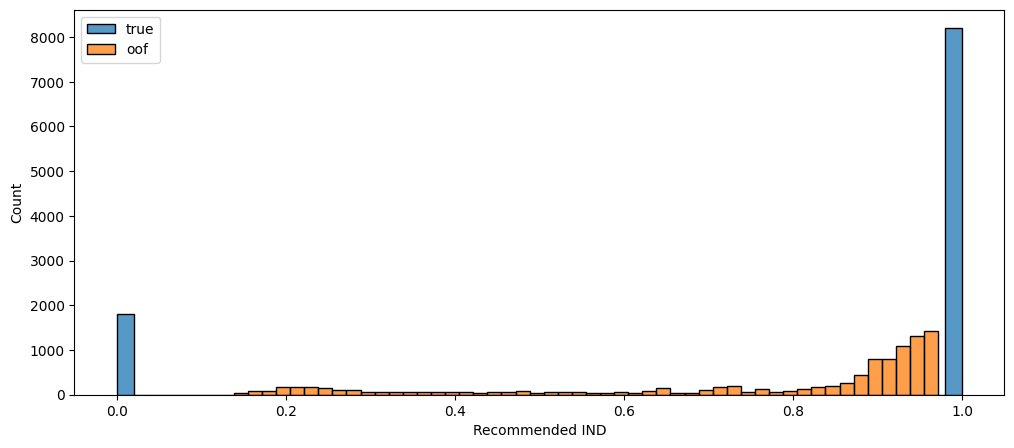

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

best_score = roc_auc_score(y_train, oof)
with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### SUbmission

In [7]:
import os

def tokenize(sample):
    return tokenizer(sample['prompt'], max_length=cfg.bert.params.max_length, truncation=True)

preds = []
for fold in range(cfg.n_splits):
    # ベストステップのモデルを取得
    fold_dir = f"../../results/009/20240831_013303/fold{fold}"
    checkpoint_dirs = [d for d in os.listdir(fold_dir) if d.startswith("checkpoint-")]
    results_dir = os.path.join(fold_dir, checkpoint_dirs[0])
    model = AutoModelForSequenceClassification.from_pretrained(results_dir)

    ds_test = Dataset.from_pandas(test_df[['prompt']].copy())
    ds_test = ds_test.map(tokenize).remove_columns(['prompt'])

    test_args = TrainingArguments(
        output_dir=cfg.data.results_dir,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        do_predict=True,
        dataloader_drop_last=False,
    )
    trainer = Trainer(
        model=model,
        args=test_args,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
    )
    predictions = torch.softmax(torch.tensor(trainer.predict(ds_test).predictions), dim=1).numpy()
    preds.append(predictions[:, 1])

pred = np.mean(preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

,target
0,0.933818
1,0.468535
2,0.935930
3,0.308901
4,0.894364
